In [1]:
%run _startup.ipynb

In [2]:
plt.style.use('bmh')

In [3]:
RANDOM_STATE = 2017

### 1. Prepare datasets

In [5]:
# Read dataset and variables
df = pd.read_pickle('data/df_main.pkl')
dict_feats = {
 'Economic Activity': 'GDP GDPC1 EXPGS PNFI INDPRO CFNAI',
 'Financial Conditions': 'TOTBKCR DPSACBW027SBOG STLFSI4 NFCI',
 'Inflation': 'CPILFESL CPIAUCSL PCE PCEPI PCEPILFE MICH',
 'Labor Market Conditions': 'PAYEMS UNRATE EMRATIO',
 'Monetary Policy Actions': 'WSECOUT'
}
list_class = ['0)-0.50%', '1)-0.25%', '2)0%', '3)+0.25%', '4)+0.50%']
# df['DFEDTAR_diff_cat'] = df['DFEDTAR_diff_lbl'].map({k:v for k,v in enumerate(list_class)})

# Create target and lag feats
df['x1'] = df['DFEDTAR_diff'].shift(1)
df['y'] = df['DFEDTAR_diff_lbl']

# Create sets
feats = [
    'GDP_pct12',
    'GDPC1_pct12',
    'EXPGS_pct12',
    'PNFI_pct12',
    'INDPRO',
    'CFNAI',
    'TOTBKCR_pct12',
    'DPSACBW027SBOG_pct12',
    'STLFSI4',
    'NFCI',
    'CPILFESL_pct12',
    'CPIAUCSL_pct12',
    'PCE_pct12',
    'PCEPI_pct12',
    'PCEPILFE_pct12',
    'MICH',
    'PAYEMS_pct12',
    'UNRATE_diff12',
    'EMRATIO_diff12',
    'WSECOUT_pct12',
    'x1',
    # 'y'
]
# filter for removing extreme target values or take all
y_max = 5
filt = df['DFEDTAR_diff'].abs() < y_max

X = df[filt][feats][1:-1]
y = df[filt]['y'][1:-1]
X_new = df[feats][-1:]

# last value prediction
y_last = df['DFEDTAR_diff_lbl'].shift(1)[1:-1].astype(int).values

# check for nulls or inf values
st = X.isnull().sum()
print(st[st != 0])
st = (X == np.inf).sum()
print(st[st != 0])

# create class weights
# dict_weights = (1 / y.value_counts(normalize = True)).to_dict()
# dict_weights = {k:1 for k,v in dict_weights.items()}

# # feature scaling
# scaler = preprocessing.StandardScaler()
# X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index = X.index)
# X_new = pd.DataFrame(scaler.transform(X_new), columns=X_new.columns, index = X_new.index)

print(X.shape, y.shape)
X[-3:]

Series([], dtype: int64)
Series([], dtype: int64)
(217, 21) (217,)


,GDP_pct12,GDPC1_pct12,EXPGS_pct12,PNFI_pct12,INDPRO,CFNAI,TOTBKCR_pct12,DPSACBW027SBOG_pct12,STLFSI4,NFCI,CPILFESL_pct12,CPIAUCSL_pct12,PCE_pct12,PCEPI_pct12,PCEPILFE_pct12,MICH,PAYEMS_pct12,UNRATE_diff12,EMRATIO_diff12,WSECOUT_pct12,x1
dt1,,,,,,,,,,,,,,,,,,,,,
2024-06-01,0.05,0.03,0.02,0.06,102.98,0.15,0.02,0.02,-0.84,-0.52,0.03,0.03,0.05,0.03,0.03,3.30,0.02,0.50,-0.20,-0.12,0.00
2024-08-01,0.06,0.03,0.05,0.05,102.54,-0.30,0.03,0.02,-0.50,-0.49,0.03,0.03,0.05,0.02,0.03,2.90,0.02,0.40,-0.40,-0.11,0.00
2024-10-01,0.05,0.03,0.05,0.06,102.55,-0.27,0.04,0.03,-0.54,-0.52,0.03,0.03,0.05,0.02,0.03,2.70,0.01,0.30,-0.30,-0.10,-0.50


In [6]:
X_new

,GDP_pct12,GDPC1_pct12,EXPGS_pct12,PNFI_pct12,INDPRO,CFNAI,TOTBKCR_pct12,DPSACBW027SBOG_pct12,STLFSI4,NFCI,CPILFESL_pct12,CPIAUCSL_pct12,PCE_pct12,PCEPI_pct12,PCEPILFE_pct12,MICH,PAYEMS_pct12,UNRATE_diff12,EMRATIO_diff12,WSECOUT_pct12,x1
dt1,,,,,,,,,,,,,,,,,,,,,
2024-11-01,0.05,0.03,0.05,0.06,102.28,-0.40,0.04,0.03,-0.58,-0.58,0.03,0.03,0.05,0.02,0.03,2.70,0.01,0.50,-0.60,-0.10,-0.25


### 2. Random Forest max_depth searching on CV

In [7]:
model = ensemble.RandomForestClassifier(
    n_estimators=500,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=0,
    warm_start=False,
    class_weight='balanced',
    ccp_alpha=0.0,
    max_samples=None,
)

In [8]:
cv = model_selection.RepeatedStratifiedKFold(
    n_splits = 4, 
    # shuffle = True, 
    random_state = RANDOM_STATE,
    n_repeats = 5,
)

In [9]:
#  searching the best max_depth
out = list()
list_depth = list(range(1, 15))
for n in list_depth:
    model.max_depth = n
    scores = model_selection.cross_val_score(
        model, 
        X, 
        y, 
        scoring='f1_weighted',
        cv=cv, 
        n_jobs=-1
    )
    scores = pd.Series(scores)
    out.append(scores.describe())

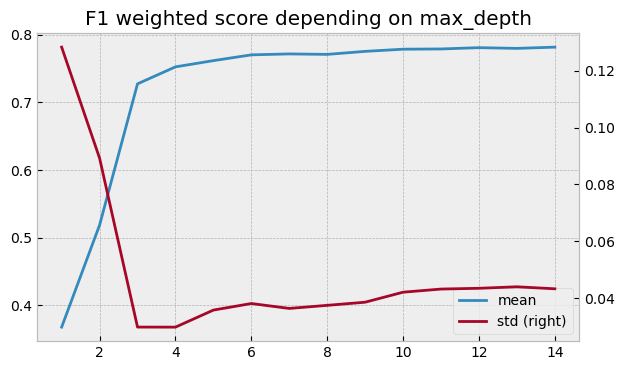

In [10]:
# plotting
_ = pd.DataFrame(out, index = list_depth)[['mean','std']].plot(secondary_y = 'std', figsize = (7,4), title = 'F1 weighted score depending on max_depth')

### 3. Random Forest evaluation on CV

In [11]:
model = ensemble.RandomForestClassifier(
    n_estimators=500,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=0,
    warm_start=False,
    class_weight='balanced',
    ccp_alpha=0.0,
    max_samples=None,
)

In [12]:
cv = model_selection.StratifiedKFold(
    n_splits = 4, 
    shuffle = True, 
    random_state = RANDOM_STATE
)

In [13]:
# report
model.max_depth = None
pred = model_selection.cross_val_predict(
    model, 
    X, 
    y, 
    cv=cv, 
    n_jobs=-1,
    method = 'predict_proba')
y_pred = pred.argmax(axis = 1)
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.15      0.24        13
           1       0.67      0.20      0.31        10
           2       0.84      0.98      0.90       155
           3       0.86      0.56      0.68        32
           4       0.86      0.86      0.86         7

    accuracy                           0.83       217
   macro avg       0.74      0.55      0.60       217
weighted avg       0.81      0.83      0.80       217



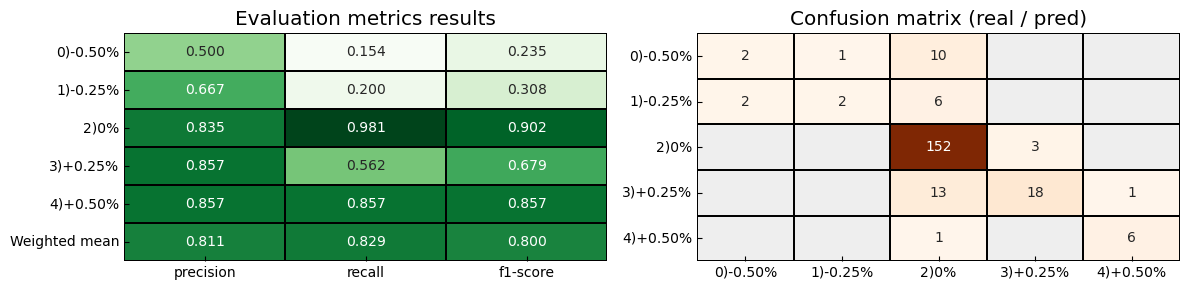

In [14]:
# heatmaps

_, ax = plt.subplots(1,2, figsize = (12,3))

# results
list_ind = ['precision', 'recall', 'f1-score', 'support']
df_res = pd.DataFrame(metrics.precision_recall_fscore_support(y, y_pred), index = list_ind, columns=list_class).T
del df_res['support']

df_scores = pd.DataFrame([{
    'precision': metrics.precision_score(y, y_pred, average = 'weighted'),
    'recall': metrics.recall_score(y, y_pred, average = 'weighted'),
    'f1-score': metrics.f1_score(y, y_pred, average = 'weighted'),
}], index = ['Weighted mean'])

df_res = pd.concat([df_res, df_scores])

_ = sns.heatmap(df_res, ax = ax[0], cmap = 'Greens', annot = True, fmt = ',.3f', annot_kws={"size": 10}, linewidth = 0.01, linecolor = 'black', cbar = False)
_ = ax[0].set_title('Evaluation metrics results')
ax[0].grid(False)

# confusion matrix (real / pred)
df_conf = pd.DataFrame(metrics.confusion_matrix(y, y_pred), index = list_class, columns = list_class)
_ = sns.heatmap(df_conf.replace(0, np.nan), ax = ax[1], cmap = 'Oranges', annot = True, fmt = ',.0f', annot_kws={"size": 10}, linewidth = 0.01, linecolor = 'black', cbar = False)
_ = ax[1].set_title('Confusion matrix (real / pred)')
ax[1].grid(False)

plt.tight_layout()


### 4. Compare with Last value prediction

In [15]:
y_pred = y_last

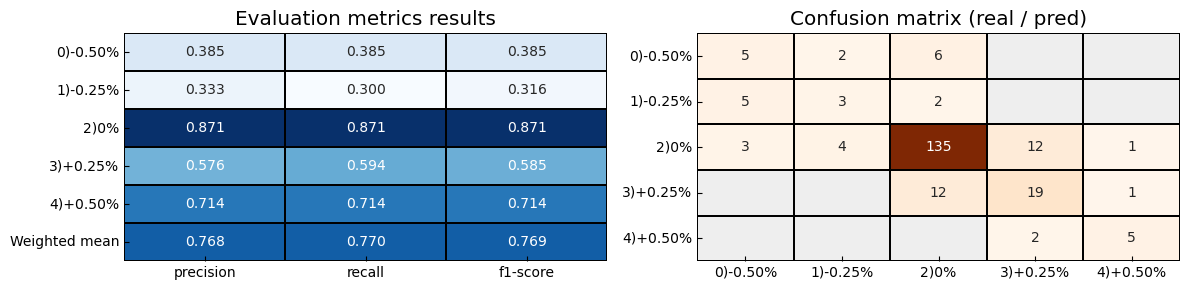

In [16]:
# heatmaps

_, ax = plt.subplots(1,2, figsize = (12,3))

# results
list_ind = ['precision', 'recall', 'f1-score', 'support']
df_res = pd.DataFrame(metrics.precision_recall_fscore_support(y, y_pred), index = list_ind, columns=list_class).T
del df_res['support']

df_scores = pd.DataFrame([{
    'precision': metrics.precision_score(y, y_pred, average = 'weighted'),
    'recall': metrics.recall_score(y, y_pred, average = 'weighted'),
    'f1-score': metrics.f1_score(y, y_pred, average = 'weighted'),
}], index = ['Weighted mean'])

df_res = pd.concat([df_res, df_scores])

_ = sns.heatmap(df_res, ax = ax[0], cmap = 'Blues', annot = True, fmt = ',.3f', annot_kws={"size": 10}, linewidth = 0.01, linecolor = 'black', cbar = False)
_ = ax[0].set_title('Evaluation metrics results')
ax[0].grid(False)

# confusion matrix (real / pred)
df_conf = pd.DataFrame(metrics.confusion_matrix(y, y_pred), index = list_class, columns = list_class)
_ = sns.heatmap(df_conf.replace(0, np.nan), ax = ax[1], cmap = 'Oranges', annot = True, fmt = ',.0f', annot_kws={"size": 10}, linewidth = 0.01, linecolor = 'black', cbar = False)
_ = ax[1].set_title('Confusion matrix (real / pred)')
ax[1].grid(False)

plt.tight_layout()


### 5. Train best model and predict

In [75]:
model = ensemble.RandomForestClassifier(
    n_estimators=500,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=0,
    warm_start=False,
    class_weight='balanced',
    ccp_alpha=0.0,
    max_samples=None,
)

In [76]:
model.fit(X,y)

RandomForestClassifier(class_weight='balanced', n_estimators=500, n_jobs=-1,
                       random_state=2017)

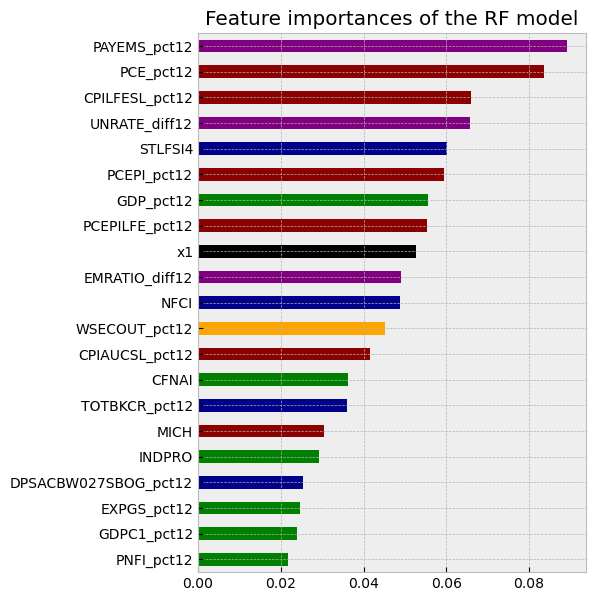

In [77]:
# feature importances - draw with colors
df_coef = pd.DataFrame(model.feature_importances_, index=feats, columns=['imp'])

dict_colors = {
    'Economic Activity': 'green',
    'Financial Conditions': 'darkblue',
    'Inflation': 'darkred',
    'Labor Market Conditions': 'purple',
    'Monetary Policy Actions': 'orange',
    'Lag': 'black'
}

dict_feats = {
    'GDP_pct12': 'Economic Activity',
    'GDPC1_pct12': 'Economic Activity',
    'EXPGS_pct12': 'Economic Activity',
    'PNFI_pct12': 'Economic Activity',
    'INDPRO': 'Economic Activity',
    'CFNAI': 'Economic Activity',
    
    'TOTBKCR_pct12': 'Financial Conditions',
    'DPSACBW027SBOG_pct12': 'Financial Conditions',
    'STLFSI4': 'Financial Conditions',
    'NFCI': 'Financial Conditions',
    
    'CPILFESL_pct12': 'Inflation',
    'CPIAUCSL_pct12': 'Inflation',
    'PCE_pct12': 'Inflation',
    'PCEPI_pct12': 'Inflation',
    'PCEPILFE_pct12': 'Inflation',
    'MICH': 'Inflation',
    
    'PAYEMS_pct12': 'Labor Market Conditions',
    'UNRATE_diff12': 'Labor Market Conditions',
    'EMRATIO_diff12': 'Labor Market Conditions',

    'WSECOUT_pct12': 'Monetary Policy Actions',
    
    'x1': 'Lag',
}

df_coef['group'] = df_coef.index.map(dict_feats)
df_coef['color'] = df_coef.group.map(dict_colors)

df_coef.sort_values('imp', inplace = True)

_ = df_coef.imp.plot(kind = 'barh', color = list(df_coef.color), figsize = (5,7), title = 'Feature importances of the RF model')

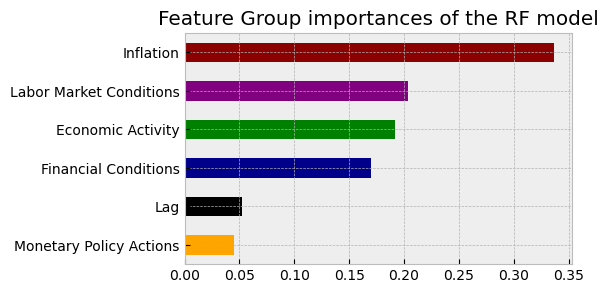

In [78]:
df_coef2 = df_coef.groupby(['group']).imp.sum().sort_values()
_ = df_coef2.plot(kind = 'barh', color = list(df_coef2.index.map(dict_colors)), figsize = (5,3), title = 'Feature Group importances of the RF model', ylabel = '')

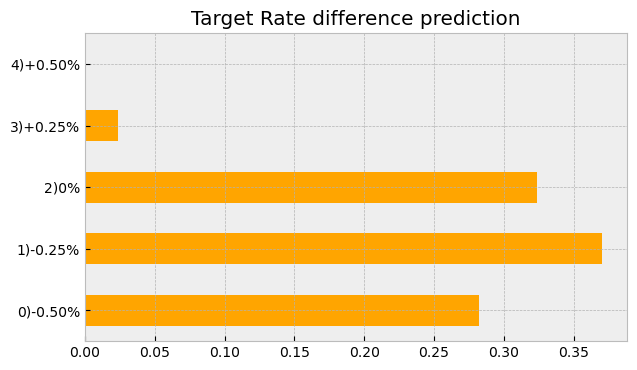

In [79]:
# predictions
preds = model.predict_proba(X_new)
df_out = pd.DataFrame(preds, columns = list_class)
_ = df_out.T[0].sort_index(ascending = True).plot(kind = 'barh', figsize = (7,4), title = 'Target Rate difference prediction', color = 'Orange')

In [80]:
# output file generation
desights_id = '0x1288155ad518c0551e650Bc20Fe728C1C36Ee223'
fout = open('prediction.csv','w')
fout.write('Desights_ID,Predicted_Class,Probability_-0.50%,Probability_-0.25%,Probability_0%,Probability_+0.25%,Probability_+0.50%\n')

val1 = df_out.idxmax(axis = 1).values[0][2:]
val2 = ','.join([str(x.round(2)) for x in df_out.values[0]])
fout.write(f'{desights_id},{val1},{val2}')
fout.close()